In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from solpo import Poisson_Equation
from FNO import FNO
from CNN import DeepCNN
from IPython.display import display, Markdown

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

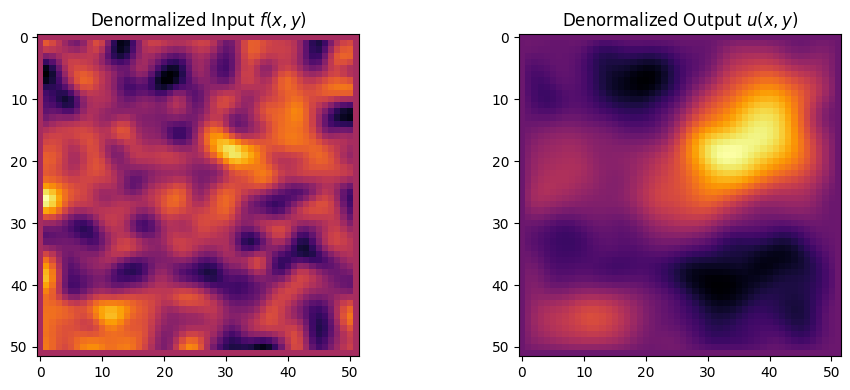

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load dataset and normalization stats
inputs1, outputs1 = torch.load("poisson_dataset_test_noise.pt")  # Shape: [N, 1, H, W]
norm_stats = torch.load("poisson_dataset_test_noise_normalization.pt", weights_only=False)# Shape: [N, 4]

# Move to device if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = inputs1.to(device)
outputs = outputs1.to(device)
norm_stats = torch.tensor(norm_stats, dtype=torch.float32).to(device)

# Extract stats
f_means = norm_stats[:, 0].view(-1, 1, 1, 1)
f_stds  = norm_stats[:, 1].view(-1, 1, 1, 1)
u_means = norm_stats[:, 2].view(-1, 1, 1, 1)
u_stds  = norm_stats[:, 3].view(-1, 1, 1, 1)

# Denormalize full dataset
inputs  = inputs  * f_stds + f_means    # [N, 1, H, W]
targets = outputs * u_stds + u_means    # [N, 1, H, W]

#Visualize example
idx = np.random.randint(0, 100)
f_img = inputs[idx, 0].cpu().numpy()
u_img = targets[idx, 0].cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(f_img, cmap='inferno')
ax1.set_title("Denormalized Input $f(x,y)$")
ax2.imshow(u_img, cmap='inferno')
ax2.set_title("Denormalized Output $u(x,y)$")
plt.tight_layout()
plt.show()

In [5]:
# Model setup
model_FNO = FNO(modes1=16, modes2=16, width=64)
model_FNO.load_state_dict(torch.load("model_FNO_noise.pt"))
model_FNO.eval()
model_FNO.to(device)
sum(p.numel() for p in model_FNO.parameters() if p.requires_grad)

8413953

In [6]:
model_CNN = DeepCNN(input_channels=1,
                    base_channels=32,
                    num_blocks=4,  
                    num_classes=1
                    )
model_CNN.load_state_dict(torch.load("model_CNN.pt"))
model_CNN.eval()
model_CNN.to(device)
sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)

74849

In [7]:
inputs_FNO = inputs1.permute(0, 2, 3, 1).to(device)
inputs_CNN = inputs1.to(device)

with torch.no_grad():
    preds_FNO = model_FNO(inputs_FNO)
    preds_CNN = model_CNN(inputs_CNN)

# Denormalization
f_means = norm_stats[:, 0].view(-1, 1, 1, 1) 
f_stds  = norm_stats[:, 1].view(-1, 1, 1, 1)
u_means = norm_stats[:, 2].view(-1, 1, 1, 1)
u_stds  = norm_stats[:, 3].view(-1, 1, 1, 1)

# For CNN: preds_CNN is [B, 1, H, W]
preds_CNN = preds_CNN * u_stds + u_means 

# For FNO: preds_FNO is [B, H, W, 1]
preds_FNO = preds_FNO * u_stds + u_means  

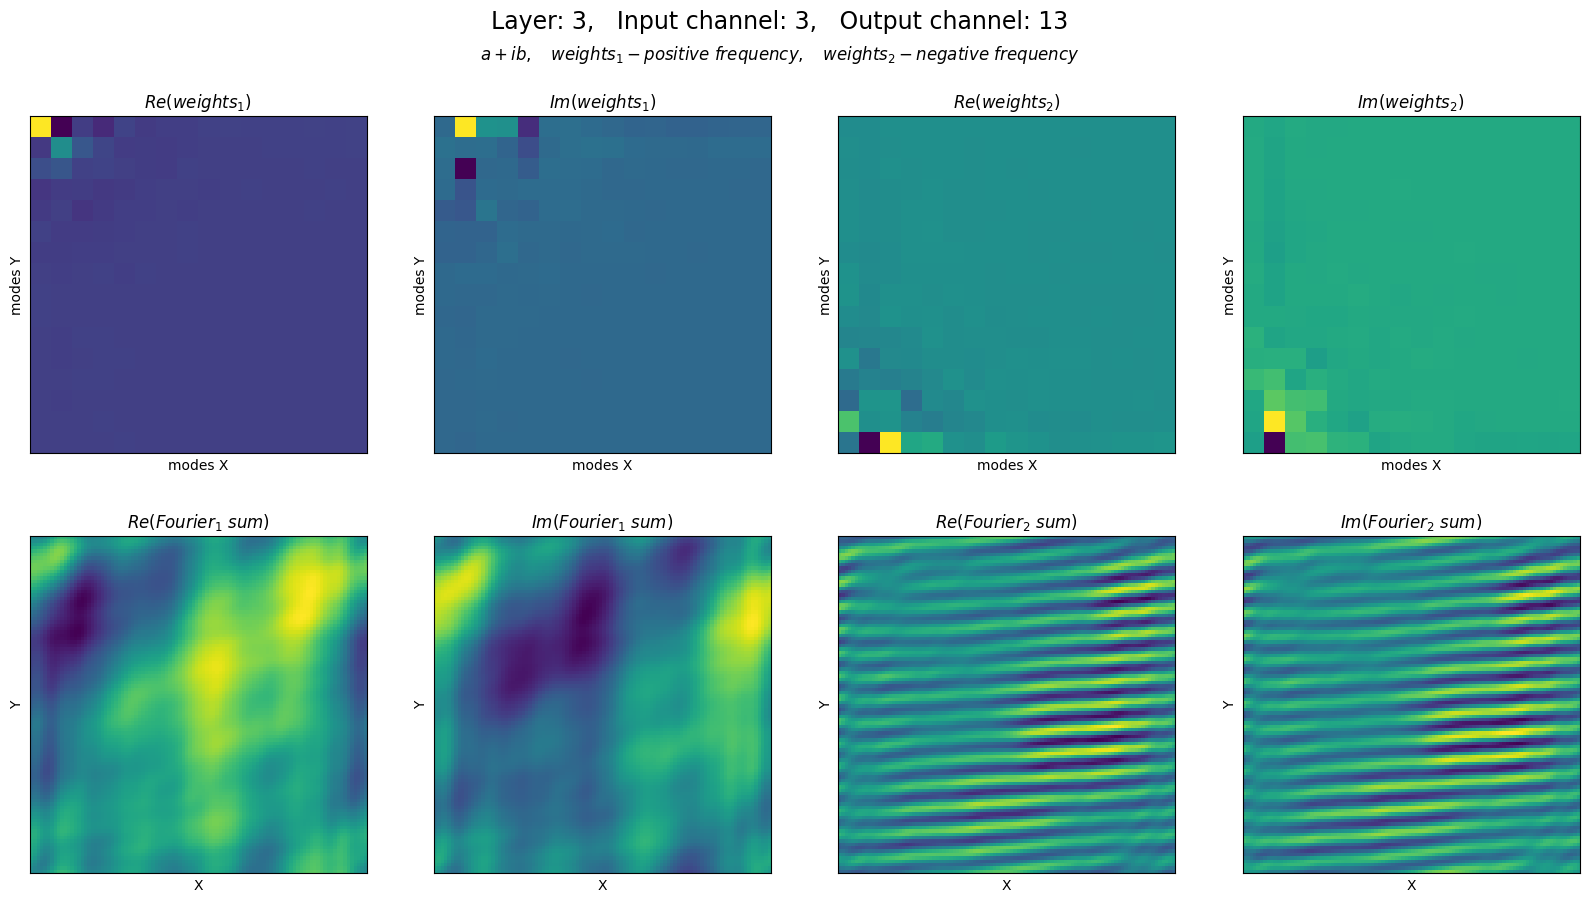

In [96]:
def plot_modes_and_operators(model, layer_idx=1, in_ch=0, out_ch=0):
    spectral_layers = [model.spec0, model.spec1, model.spec2, model.spec3]
    layer = spectral_layers[layer_idx]

    weights1 = layer.weights1[in_ch, out_ch].detach().cpu()
    weights2 = layer.weights2[in_ch, out_ch].detach().cpu()

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    colormap = 'viridis'

    axes[0][0].imshow(weights1.real.numpy(), cmap=colormap)
    axes[0][0].set_title("$Re(weights_1)$")

    axes[0][1].imshow(weights1.imag.numpy(), cmap=colormap)
    axes[0][1].set_title("$Im(weights_1)$")

    axes[0][2].imshow(weights2.real.numpy(), cmap=colormap)
    axes[0][2].set_title("$Re(weights_2)$")

    axes[0][3].imshow(weights2.imag.numpy(), cmap=colormap)
    axes[0][3].set_title("$Im(weights_2)$")

    for i in range(4):
        axes[0][i].set_xlabel("modes X")
        axes[0][i].set_ylabel("modes Y")
        axes[0][i].set_xticks([])
        axes[0][i].set_yticks([])

    grid_size = 100

    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y, indexing='ij')

    modes1_num, modes2_num = weights1.shape[0], weights1.shape[1]
    combined_field1 = np.zeros((grid_size, grid_size), dtype=np.complex128)
    combined_field2 = np.zeros((grid_size, grid_size), dtype=np.complex128)


    for i in range(modes1_num):
        for j in range(modes2_num):
            coeff1 = weights1[i, j].item()  # complex scalar --> C_{m,n}
            coeff2 = weights2[i, j].item() 
            basis = np.exp(2j * np.pi * (i * X + j * Y))  # complex basis function --> 1j is the imaginary unit
            combined_field1 += coeff1 * basis 
            combined_field2 += coeff2 * basis 

    real1, imaginary1, real2, imaginary2 = np.real(combined_field1), np.imag(combined_field1), np.real(combined_field2), np.imag(combined_field2)

    axes[1][0].imshow(real1, cmap=colormap)
    axes[1][0].set_title(r"$Re(Fourier_1 \ sum)$")

    axes[1][1].imshow(imaginary1, cmap=colormap)
    axes[1][1].set_title(r"$Im(Fourier_1 \ sum)$")

    axes[1][2].imshow(real2, cmap=colormap)
    axes[1][2].set_title(r"$Re(Fourier_2 \ sum)$")

    axes[1][3].imshow(imaginary2, cmap=colormap)
    axes[1][3].set_title(r"$Im(Fourier_2 \ sum)$")

    for i in range(4):
        axes[1][i].set_xlabel("X")
        axes[1][i].set_ylabel("Y")
        axes[1][i].set_xticks([])
        axes[1][i].set_yticks([])
    
    fig.suptitle(f'Layer: {layer_idx},   Input channel: {in_ch},   Output channel: {out_ch}', fontsize=17)
    fig.text(0.5, 0.93, r'$a+ib, \quad weights_1 - positive \ frequency, \quad weights_2 - negative \ frequency$', ha='center', fontsize=12)
    
    plt.show()


plot_modes_and_operators(model=model_FNO, layer_idx=3, in_ch=3, out_ch=13)

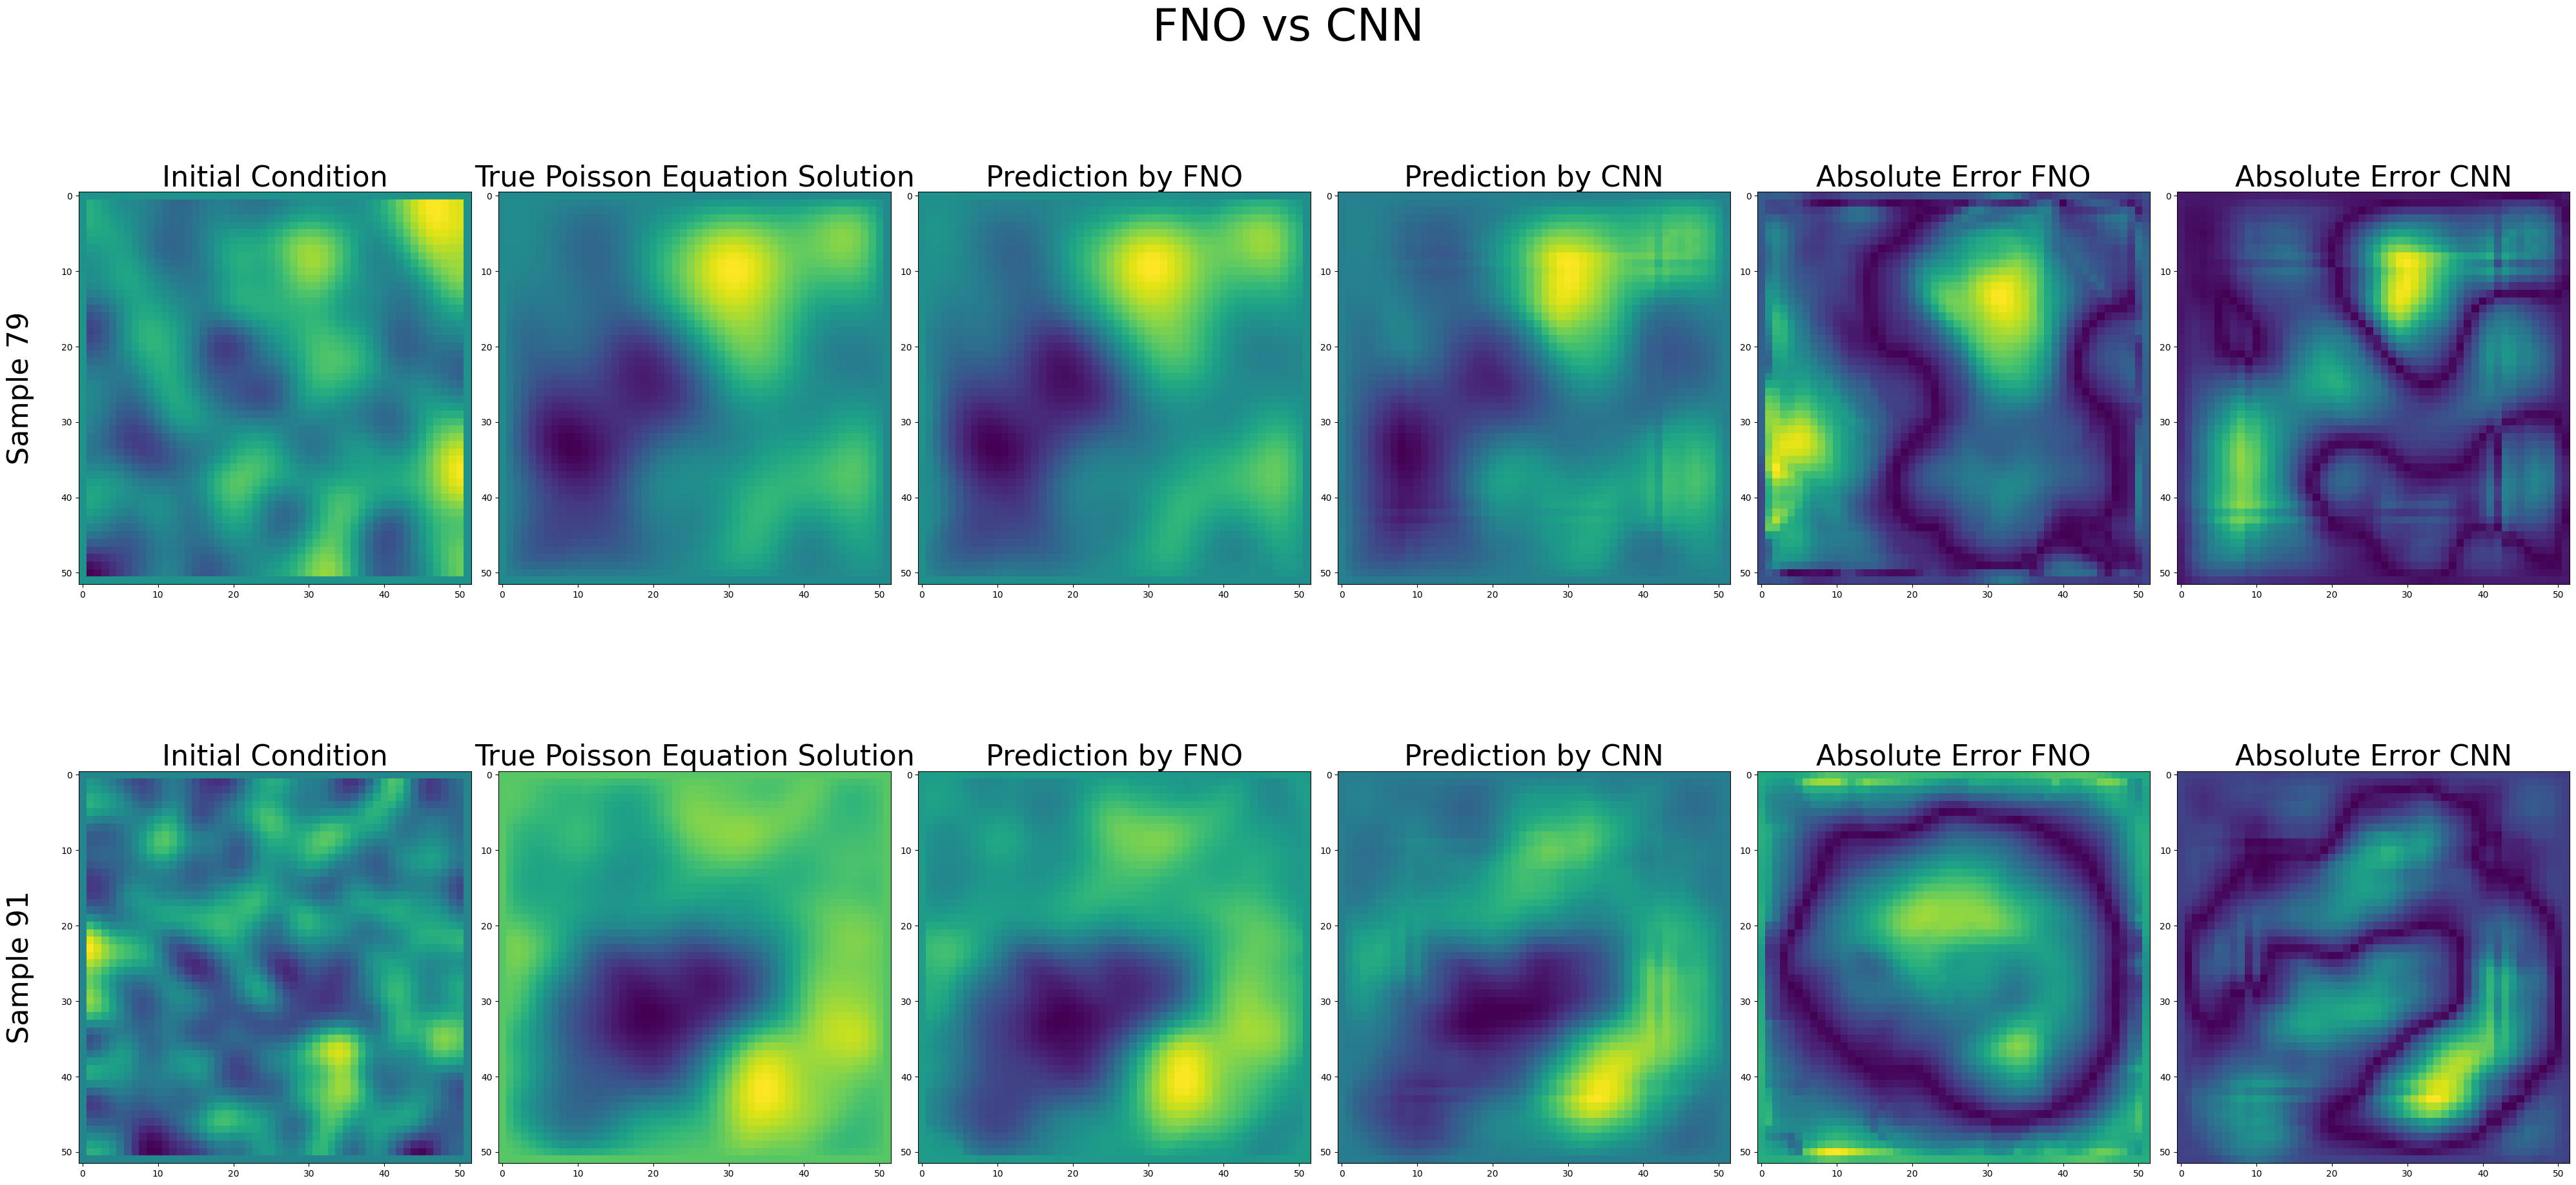

In [9]:
n_samples = 2

initial_condition = []
poisson_solution  = []
predicition_FNO   = []
predicition_CNN   = []
sample_index      = []

for i in range(n_samples):
    rand_num = torch.randint(1, 100, (1,))
    idx = rand_num.item()
    sample_index.append(idx)
    Xf = inputs[idx].squeeze().cpu()
    initial_condition.append(Xf)
    Zi = targets[idx].squeeze().cpu()
    poisson_solution.append(Zi)
    Zp0 = preds_FNO[idx].squeeze().cpu()
    predicition_FNO.append(Zp0)
    Zp1 = preds_CNN[idx].squeeze().cpu()
    predicition_CNN.append(Zp1)

fig, axes = plt.subplots(ncols=6, nrows=n_samples, figsize=(40, 10*n_samples))
fontsize = 32
for i in range(n_samples):
    axes[i][0].imshow(initial_condition[i], cmap='viridis')
    axes[i][0].set_title("Initial Condition", fontsize=fontsize)
    axes[i][1].imshow(poisson_solution[i], cmap='viridis')
    axes[i][1].set_title("True Poisson Equation Solution", fontsize=fontsize)
    axes[i][2].imshow(predicition_FNO[i], cmap='viridis')
    axes[i][2].set_title("Prediction by FNO", fontsize=fontsize)
    axes[i][3].imshow(predicition_CNN[i], cmap='viridis')
    axes[i][3].set_title("Prediction by CNN", fontsize=fontsize)
    axes[i][4].imshow(abs(poisson_solution[i] - predicition_FNO[i]), cmap='viridis')
    axes[i][4].set_title("Absolute Error FNO", fontsize=fontsize)
    axes[i][5].imshow(abs(poisson_solution[i] - predicition_CNN[i]), cmap='viridis')
    axes[i][5].set_title("Absolute Error CNN", fontsize=fontsize)


    axes[i][0].set_ylabel(f"Sample {sample_index[i]}", fontsize=fontsize, rotation=90, labelpad=30)
plt.tight_layout()
fig.suptitle('FNO vs CNN', fontsize=50, y=1.02)
plt.savefig('Comparison_Pixels.pdf', bbox_inches='tight')
plt.show()

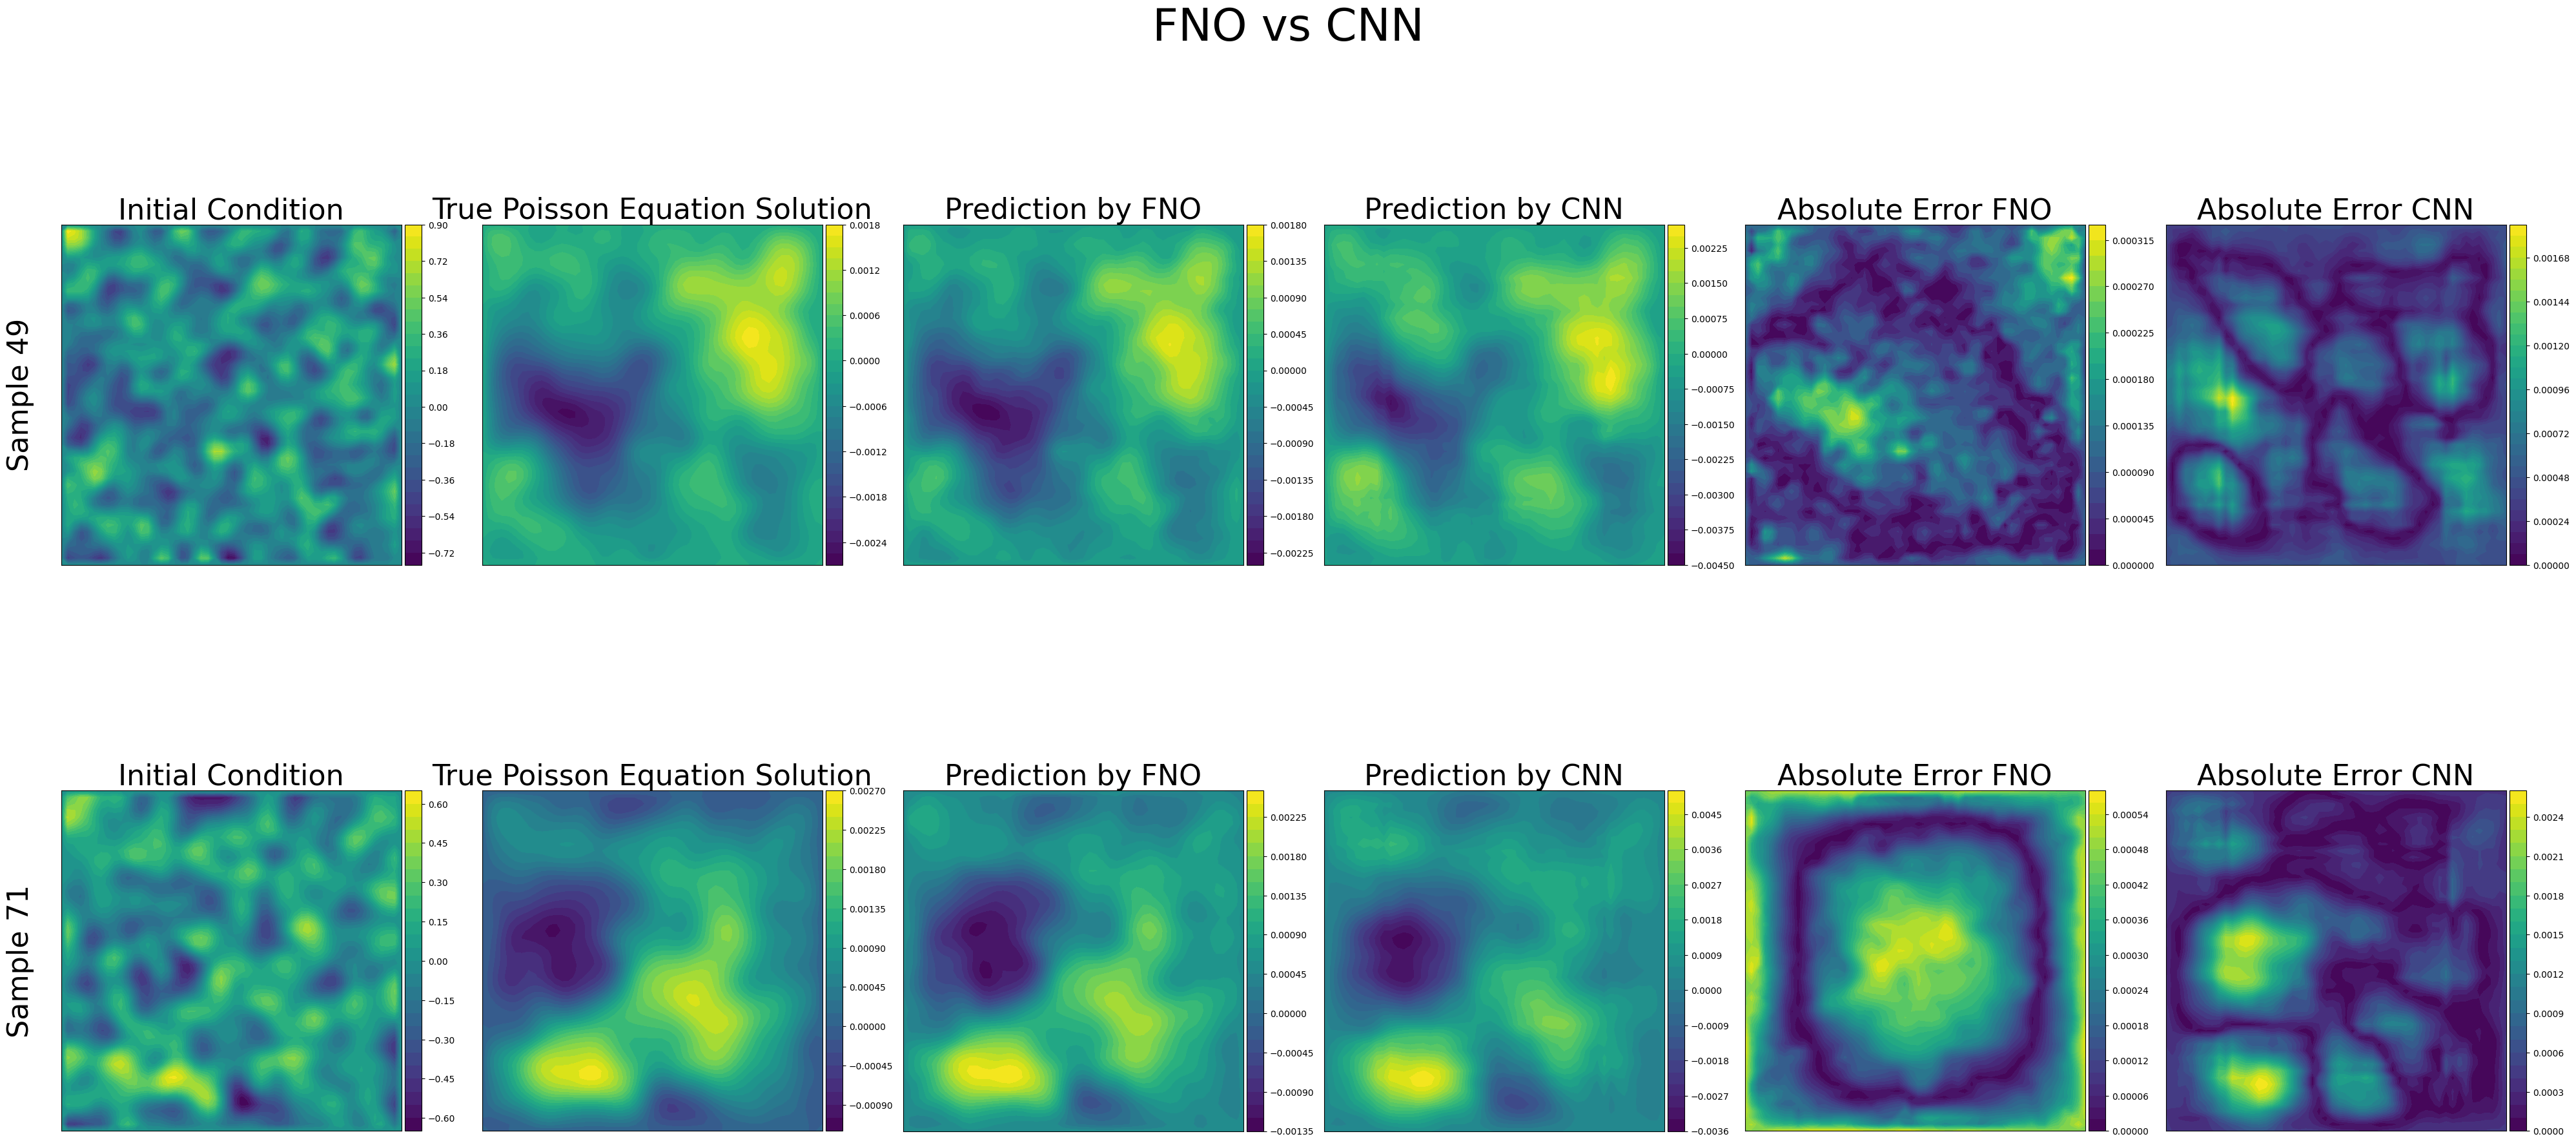

In [10]:
extent = [0, 2, 0, 2] 
n_samples = 2
epsilon = 1e-3

initial_condition = []
poisson_solution  = []
predicition_FNO   = []
predicition_CNN   = []
sample_index      = []

for i in range(n_samples):
    rand_num = torch.randint(1, 100, (1,))
    idx = rand_num.item()
    sample_index.append(idx)
    Xf = inputs[idx].squeeze().cpu()
    initial_condition.append(Xf)
    Zi = targets[idx].squeeze().cpu()
    poisson_solution.append(Zi)
    Zp0 = preds_FNO[idx].squeeze().cpu()
    predicition_FNO.append(Zp0)
    Zp1 = preds_CNN[idx].squeeze().cpu()
    predicition_CNN.append(Zp1)

fig, axes = plt.subplots(ncols=6, nrows=n_samples, figsize=(40, 10*n_samples))
fontsize = 32
contour_num = 30
for i in range(n_samples):

    cs0 = axes[i][0].contourf(initial_condition[i], levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][0].set_title("Initial Condition", fontsize=fontsize)
    cs1 = axes[i][1].contourf(poisson_solution[i], levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][1].set_title("True Poisson Equation Solution", fontsize=fontsize)
    cs2 = axes[i][2].contourf(predicition_FNO[i], levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][2].set_title("Prediction by FNO", fontsize=fontsize)
    cs3 = axes[i][3].contourf(predicition_CNN[i], levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][3].set_title("Prediction by CNN", fontsize=fontsize)
    cs4 = axes[i][4].contourf(abs(poisson_solution[i] - predicition_FNO[i]), levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][4].set_title("Absolute Error FNO", fontsize=fontsize)
    cs5 = axes[i][5].contourf(abs(poisson_solution[i] - predicition_CNN[i]), levels=contour_num, cmap='viridis', extent=extent, origin="lower")
    axes[i][5].set_title("Absolute Error CNN", fontsize=fontsize)

    axes[i][0].set_ylabel(f"Sample {sample_index[i]}", fontsize=fontsize, rotation=90, labelpad=30)
    
    for j in range(6):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
    
    for j, cs in enumerate([cs0, cs1, cs2, cs3, cs4, cs5]):
        divider = make_axes_locatable(axes[i][j])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(cs, ax=axes[i][j], cax=cax)
        axes[i][j].set_aspect('equal')
        
plt.tight_layout()

fig.suptitle('FNO vs CNN', fontsize=50, y=1.02)
plt.savefig('Comparison_Contours.pdf', bbox_inches='tight')
plt.show()

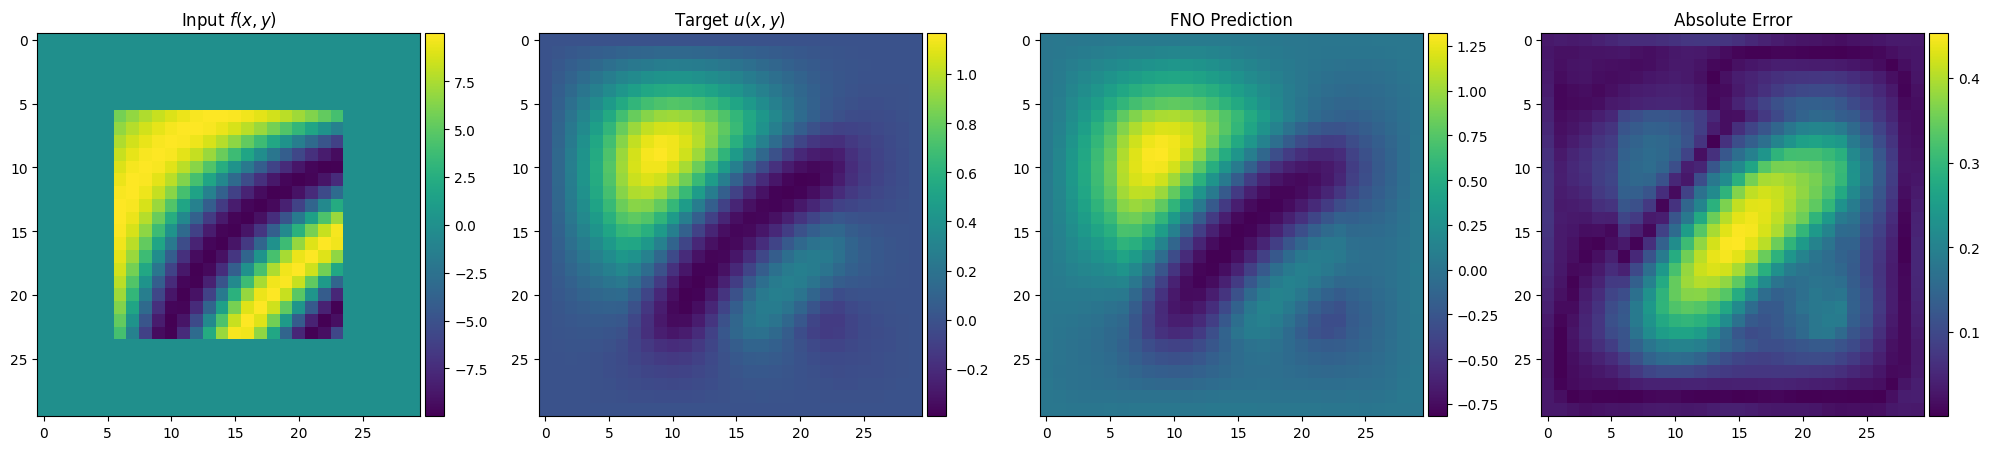

In [62]:

H = 3
n = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Source function (you can pick one; here’s the last one)
def f_raw(x, y):
    x_shifted = x - H / 2
    y_shifted = y - H / 2
    r = np.sqrt(x_shifted**2 + y_shifted**2)
    theta = np.arctan2(y_shifted, x_shifted)
    f = np.where(np.sin(9 * theta) * 3 >= r**2, 3, 0)
    f = np.sin(x * y * 5)
    f = np.where(
        (x > 0.5) & (x < H - 0.5) & (y > 0.5) & (y < H - 0.5),
        1, 0
    )
    return f * 10*np.sin(2*x*y)

# Meshgrid
x = np.linspace(0, H, n - 2)
y = np.linspace(0, H, n - 2)
X, Y = np.meshgrid(x, y)

# Raw function values
f_vals_raw = f_raw(X, Y)

# Solve Poisson equation
PE = Poisson_Equation(H=H, n=n - 2, IC=lambda x, y: f_vals_raw)
u_raw = PE.solve_Poisson_Equation()

# Normalize input for FNO
f_mean, f_std = f_vals_raw.mean(), f_vals_raw.std()
f_norm = (f_vals_raw - f_mean) / (f_std + 1e-7)

# Prepare tensor
f_padded = np.pad(f_norm, pad_width=1, mode='edge')
input_tensor = torch.tensor(f_padded, dtype=torch.float32).unsqueeze(-1).unsqueeze(0).to(device)

# Load model
model = FNO(modes1=16, modes2=16, width=64)
model.load_state_dict(torch.load("model_FNO_noise.pt"))
model.eval().to(device)

# Predict
with torch.no_grad():
    pred_tensor = model(input_tensor)

# Denormalize output
pred_img_norm = pred_tensor.squeeze().cpu().numpy()
pred_img = pred_img_norm * (f_std + 1e-7) + f_mean
pred_img = pred_img*(H/(n+1))

# Plot results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
titles = ["Input $f(x,y)$", "Target $u(x,y)$", "FNO Prediction", "Absolute Error"]
images = [np.pad(f_vals_raw, pad_width=1, mode='edge'), u_raw, pred_img, np.abs(pred_img - u_raw)]

for ax, title, img in zip(axes, titles, images):
    im = ax.imshow(img, cmap="viridis")
    ax.set_title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)


plt.tight_layout()
plt.show()

In [89]:

def MSE(y_t, y_p):
    return np.mean((y_t - y_p)**2)

mse = 0

for i in range(len(inputs)):
    y_t = targets[i].squeeze().cpu().numpy()
    y_p = preds_FNO[i].squeeze().cpu().numpy()
    mse += MSE(y_t, y_p)

u_max = np.max(targets.squeeze().cpu().numpy())
u_min = np.min(targets.squeeze().cpu().numpy())

up_max = np.max(preds_FNO.squeeze().cpu().numpy())
up_min = np.min(preds_FNO.squeeze().cpu().numpy())

mse = mse/len(inputs)
num_list = []
exp_list = []
for o in [mse, u_max, u_min, up_max, up_min]:
    num_list.append(f"{o:.2e}".split('e')[0])
    exp_list.append(int(f"{o:.2e}".split('e')[1]))

display(Markdown(f"$\\mathrm{{MSE}} = {num_list[0]} \\times 10^{{{exp_list[0]}}}$"))
display(Markdown(f"$\\max(u) = {num_list[1]} \\times 10^{{{exp_list[1]}}}$, $\\quad$ $\\min(u) = {num_list[2]} \\times 10^{{{exp_list[2]}}}$"))
display(Markdown(f"$\\max(\\hat{{u}}) = {num_list[3]} \\times 10^{{{exp_list[3]}}}$, $\\quad$ $\\min(\\hat{{u}}) = {num_list[4]} \\times 10^{{{exp_list[4]}}}$"))

$\mathrm{MSE} = 1.78 \times 10^{-7}$

$\max(u) = 5.07 \times 10^{-3}$, $\quad$ $\min(u) = -5.82 \times 10^{-3}$

$\max(\hat{u}) = 5.25 \times 10^{-3}$, $\quad$ $\min(\hat{u}) = -5.85 \times 10^{-3}$